<a href="https://colab.research.google.com/github/evinracher/3010090-ontological-engineering/blob/main/practice/agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller: LangGraph para Chatbots Inteligentes (Gemini)
**Objetivo:** practicar desde lo básico hasta memoria y checkpointing (incluye time travel y streaming).  
**Requisitos:** tener `GOOGLE_API_KEY` en Colab Secrets.

Estructura del taller:
1) Tema + ejemplo corto  
2) “Tu turno”: modifica/crea tu propio código  
3) Preguntas teóricas y “¿qué pasa si…?”

In [1]:
%pip install -U langgraph langchain-groq pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.4/501.4 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.6/212.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.0 MB/s eta 0:00:00


In [2]:

import os
from google.colab import userdata

if not os.getenv("GROQ_API_KEY"):
    try:
        os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
    except Exception:
        pass

print("GROQ_API_KEY:", "✅" if os.getenv("GROQ_API_KEY") else "⚠️")

GROQ_API_KEY: ✅


In [3]:
# For visualization
from IPython.display import Image, display

In [33]:
from typing import Literal
from pydantic import BaseModel, Field
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnableBranch
from langchain_core.output_parsers import StrOutputParser

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langchain_groq import ChatGroq
classifier_LLM = ChatGroq(model="llama-3.1-8b-instant", temperature=0.2)
print("✅ classifier_LLM listo:", classifier_LLM.model_name)

classifier_prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
     You are a classifier. Your tasks is to classifier the user intention
     choose:
     - 'domainSearch' if the user is asking about Colombian Labor Laws
     - 'summarize' if the user is asking to summarize a document from the Colombian Labor Law domain (e.g.: a law article, a law)
     - 'compare' if the user is asking to compare two or more documents from the Colombian Labor Law domain
     - 'generalSearch' if the user is asking a general question
     Answer only with the JSOM scheme asked.
    """
    ),
    ("user", "question: {question}")
])

general_prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
     Answer the user question in Spanish. At the end of the answer, add a note that says:

     **Nota:** Soy un asistente especializado en derecho laboral colombiano. Esta respuesta se proporciona a nivel general y puede no reflejar información actualizada o especializada sobre este tema. Se recomienda consultar una fuente experta o profesional en el área correspondiente.
    """
    ),
    ("user", "question: {question}")
])

class QuestionState(TypedDict):
    question: str

class ClassifyState(TypedDict):
    question: str
    intent: Literal["domainSearch", "summarize", "compare", "generalSearch"] = Field(
        description="User intent."
    )

class ResponseState(TypedDict):
  question: str
  intent: Literal["domainSearch", "summarize", "compare", "generalSearch"] = Field(
        description="User intent."
    )
  response: str

classifier_chain = classifier_prompt | classifier_LLM.with_structured_output(ClassifyState)
general_chain = general_prompt | classifier_LLM

def classifier(state: QuestionState):
    question = state["question"]
    classification = classifier_chain.invoke({ "question": question})
    return {
        "question": classification["question"],
        "intent": classification["intent"]
        }

def general_search(state: ClassifyState):
    question = state["question"]
    res = general_chain.invoke({"question": question})
    print("GENERAL SEARCH RESULT:", res)

    return {"response": res.content}

def rag(state: ClassifyState):
    question = state["question"]
    intent = state["intent"]
    print("RAG REQUEST RESULT:", question, intent)

    res = classifier_LLM.invoke(f"Say which intent is this one: {intent}")

    return {"response": res.content}

def classify_route(state: ClassifyState) -> Literal["rag","general_search"]:
  intent = state["intent"]
  return "general_search" if intent == "generalSearch" else "rag"

graph = StateGraph(ResponseState)

graph.add_node("classifier", classifier)
graph.add_node("general_search", general_search)
graph.add_node("rag", rag)

graph.add_edge(START, "classifier")
graph.add_conditional_edges("classifier", classify_route)
graph.add_edge("rag", END)
graph.add_edge("general_search", END)

chat = graph.compile()

print(chat.invoke({"question":"Como se calculan las cesantías?"})["response"])
print(chat.invoke({"question":"Qué es el sol"})["response"])

✅ classifier_LLM listo: llama-3.1-8b-instant
RAG REQUEST RESULT: Como se calculan las cesantías? domainSearch
I'm not provided with the text for the intent 'domainSearch'. However, based on general knowledge, the intent 'domainSearch' is likely related to searching for a domain name. 

This intent could be used in a conversational interface, such as a chatbot or voice assistant, to help users find available domain names for their websites or online projects.
GENERAL SEARCH RESULT: content='El Sol es la estrella central del sistema solar y la fuente principal de luz y calor para nuestro planeta. Es una estrella de tipo G2V, lo que significa que es una estrella de secuencia principal de la clase G2, que es una de las más comunes en la Vía Láctea.\n\nEl Sol es una esfera de gas incandescente que se encuentra a unos 149,6 millones de kilómetros de la Tierra. Su diámetro es aproximadamente 1.392.684 kilómetros, lo que es unas 109 veces más grande que el diámetro de la Tierra.\n\nEl Sol emit

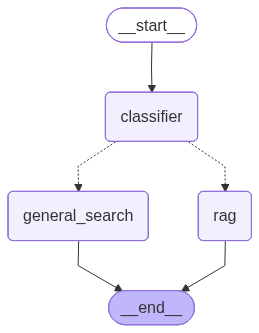

In [34]:
display(Image(chat.get_graph().draw_mermaid_png()))


### Tu turno
Cambia la regla de routing:
- Si el texto contiene “pasos” → usa un nodo `dar_pasos` (lista 1-3 items).

### Preguntas
- ¿Qué pasa si tu función `route` devuelve un nombre de nodo que no existe?
- ¿Qué pasa si ambos caminos llevan a más nodos y no solo a END?

## 3) Gestión de conversación: historial, truncamiento y resumen

### Ejemplo 3: MessagesState + add_messages

In [ ]:
from langgraph.graph import MessagesState, add_messages
from langchain_core.messages import HumanMessage, AIMessage

# MessagesState ya trae la key "messages" con reducer append-only
def chatbot_node(state: MessagesState):
    resp = llm.invoke(state["messages"])
    return {"messages": [resp]}

g3 = StateGraph(MessagesState)

g3.add_node("chat", chatbot_node)

g3.add_edge(START, "chat")
g3.add_edge("chat", END)

app3 = g3.compile()

state0 = {"messages": [HumanMessage(content="Hola, ¿quién eres?")]}
out = app3.invoke(state0)

out["messages"][-1].content

'Hola. Soy un modelo de inteligencia artificial desarrollado por Meta, diseñado para proporcionar información y responder a preguntas en un rango de temas. Estoy aquí para ayudarte con cualquier cosa que necesites. ¿En qué puedo ayudarte hoy?'

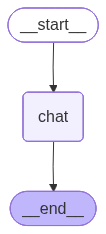

In [ ]:
display(Image(app3.get_graph().draw_mermaid_png()))

### Tu turno
- Haz 2 turnos: agrega el mensaje del usuario y vuelve a invocar.
- Observa cómo crece la lista `messages`.
- Implementa una paso para quitar mensajes
- Implementa una paso para resumir mensajes

### Preguntas
- ¿Por qué guardar todo el historial puede ser costoso?
- ¿Qué ventajas tiene “resumir” vs “borrar” mensajes?